In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler


In [3]:
matHealth = pd.read_csv('PAHealth_MaternalChildHealth_20221127.csv').iloc[0:, 1:]
print(matHealth.shape)
counties = matHealth['County0']


(68, 49)


In [4]:
matHealth['MICH-01_MetGoal'][matHealth['MICH-01_MetGoal']=='No'] = 0
matHealth['MICH-01_MetGoal'][matHealth['MICH-01_MetGoal']=='DSU'] = 0
matHealth['MICH-01_MetGoal'][matHealth['MICH-01_MetGoal']=='Yes'] = 1
matHealth['MICH-02_MetGoal'][matHealth['MICH-02_MetGoal']=='No'] = 0
matHealth['MICH-02_MetGoal'][matHealth['MICH-02_MetGoal']=='DSU'] = 0
matHealth['MICH-02_MetGoal'][matHealth['MICH-02_MetGoal']=='Yes'] = 1
matHealth['MICH-07_MetGoal'][matHealth['MICH-07_MetGoal']=='No'] = 0
matHealth['MICH-07_MetGoal'][matHealth['MICH-07_MetGoal']=='DSU'] = 0
matHealth['MICH-07_MetGoal'][matHealth['MICH-07_MetGoal']=='Yes'] = 1

matHealth['goals_met'] = matHealth['MICH-01_MetGoal'].astype(float) + matHealth['MICH-02_MetGoal'].astype(float) + matHealth['MICH-07_MetGoal'].astype(float)
matHealth['goals_met']

0     0.0
1     2.0
2     1.0
3     0.0
4     1.0
     ... 
63    2.0
64    1.0
65    3.0
66    0.0
67    1.0
Name: goals_met, Length: 68, dtype: float64

In [5]:
matHealth = matHealth[['County0', 'goals_met']]
matHealth

,County0,goals_met
0,Pennsylvania,0.0
1,Adams,2.0
2,Allegheny,1.0
3,Armstrong,0.0
4,Beaver,1.0
...,...,...
63,Washington,2.0
64,Wayne,1.0
65,Westmoreland,3.0
66,Wyoming,0.0


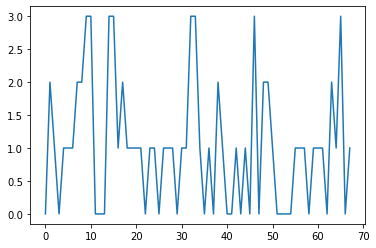

In [6]:
counties = matHealth['County0']
outcome = matHealth['goals_met']
outcome = pd.DataFrame(outcome)
outcome.apply(lambda x: x.fillna(x.mean(), inplace=True)) #imputing with mean

plt.plot(outcome)

In [7]:
goals_met = pd.concat([pd.DataFrame(counties), outcome], axis=1)

In [8]:
health_outcomes = pd.read_csv('oversampled_health_outcomes.csv')
health_outcomes

,county_name,population,pop_change_2010,perc_under_18,perc_csec,perc_lowbirth,perc_prenat_1tri,perc_preterm,perc_non_smoke,fert_15_44,...,perc_smoker,hiv_tested,perc_no_healthins,perc_obese,perc_routine_checkup,beds_per_1000,inpatient_occupancy_rate,admission_per_1000,Total_MetGoals,MetGoal_Reached
0,Potter,16526.0,-5.3,20.3,35.9,6.2,77.8,11.3,78.7,68.9,...,21.0,33.0,8.0,36.0,89.0,1.5,49.2,91.8,2.0,1
1,Wyoming,26794.0,-5.2,19.4,32.4,7.4,71.2,10.6,76.9,56.8,...,24.0,45.0,11.0,29.0,89.0,0.4,20.8,12.2,2.0,1
2,Lehigh,369318.0,5.7,22.5,29.9,8.2,73.9,9.6,91.6,60.7,...,18.0,45.0,6.0,32.0,89.0,4.7,74.4,245.7,3.0,1
3,Indiana,84073.0,-5.4,17.6,24.0,7.3,65.7,7.6,85.0,48.0,...,21.0,37.0,8.0,39.0,89.0,2.0,42.1,73.1,3.0,1
4,Schuylkill,141359.0,-4.7,19.7,32.1,8.5,67.6,10.1,77.0,59.0,...,17.0,45.0,7.0,34.0,83.0,1.7,65.2,70.6,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Dauphin,278299.0,3.8,22.3,30.4,9.5,71.6,10.3,88.4,64.7,...,20.0,42.0,16.0,32.0,87.0,4.1,77.3,223.0,0.0,0
147,Fulton,14530.0,-2.1,19.5,31.4,8.5,77.3,10.8,83.4,59.8,...,17.0,39.0,14.0,32.0,83.0,1.4,30.2,39.8,0.0,0
148,Luzerne,317417.0,-1.1,19.8,35.1,8.2,68.7,10.3,83.6,58.6,...,24.0,45.0,11.0,29.0,89.0,2.5,53.7,108.3,0.0,0
149,Pike,55809.0,-2.7,17.2,33.2,8.1,68.1,9.5,85.3,48.3,...,19.0,42.0,10.0,35.0,88.0,0.0,NaN,0.0,0.0,0


In [9]:
merged = health_outcomes.merge(goals_met, left_on='county_name', right_on='County0')
merged = merged.drop(columns = ['County0', 'perc_lowbirth', 'perc_preterm', 'admission_per_1000', 
                               'Total_MetGoals', 'MetGoal_Reached'])
merged.drop_duplicates()

,county_name,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,...,chlam_per_100000,gono_per_100000,perc_smoker,hiv_tested,perc_no_healthins,perc_obese,perc_routine_checkup,beds_per_1000,inpatient_occupancy_rate,goals_met
0,Potter,16526.0,-5.3,20.3,35.9,77.8,78.7,68.9,27.7,145.7,...,178.2,NaN,21.0,33.0,8.0,36.0,89.0,1.5,49.2,0.0
1,Wyoming,26794.0,-5.2,19.4,32.4,71.2,76.9,56.8,16.3,83.4,...,155.2,NaN,24.0,45.0,11.0,29.0,89.0,0.4,20.8,0.0
2,Lehigh,369318.0,5.7,22.5,29.9,73.9,91.6,60.7,19.8,70.9,...,509.8,102.8,18.0,45.0,6.0,32.0,89.0,4.7,74.4,1.0
3,Indiana,84073.0,-5.4,17.6,24.0,65.7,85.0,48.0,9.5,41.8,...,390.5,34.7,21.0,37.0,8.0,39.0,89.0,2.0,42.1,3.0
4,Schuylkill,141359.0,-4.7,19.7,32.1,67.6,77.0,59.0,20.9,88.7,...,235.7,34.5,17.0,45.0,7.0,34.0,83.0,1.7,65.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Juniata,24763.0,0.5,22.1,21.9,65.7,89.1,68.0,14.8,105.2,...,135.2,16.2,19.0,37.0,7.0,34.0,88.0,0.0,NaN,1.0
147,Delaware,566747.0,1.4,22.1,31.6,69.6,93.6,58.8,10.7,42.9,...,535.9,151.0,12.0,50.0,6.0,26.0,90.0,1.8,66.4,1.0
148,Susquehanna,40328.0,-7.0,18.4,31.8,64.2,78.0,61.4,19.3,95.0,...,100.9,10.7,19.0,42.0,10.0,35.0,88.0,1.2,27.6,0.0
149,Clinton,38632.0,-1.5,19.5,27.3,68.8,82.9,52.5,15.2,50.3,...,231.3,25.8,21.0,33.0,8.0,36.0,89.0,0.6,27.9,1.0


In [10]:
adi = pd.read_csv('countyLevel_ACS_ADI.csv')
adi['county'] = adi['county'].str.replace(' County', '')
cols = ['county', 'population_White', 'population_Black', 'population_Native', 'population_Asian', 'population_NativeHawaiian_PacificIslander', 'population_OtherRace', 'ADI_STATERNK_INT_mean']
adi = adi[cols]
adi['population_White'] = adi['population_White']*100
adi['population_Black'] = adi['population_Black']*100
adi['population_Asian'] = adi['population_Asian']*100
adi['population_Native'] = adi['population_Native']*100
adi['population_NativeHawaiian_PacificIslander'] = adi['population_NativeHawaiian_PacificIslander']*100
adi['population_OtherRace'] = adi['population_OtherRace']*100
adi

,county,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
0,Adams,92.800140,1.591199,0.150058,0.705467,0.000000,2.242100,3.627907
1,Allegheny,79.033717,12.995699,0.117943,3.923242,0.042105,0.820844,5.867155
2,Armstrong,97.330008,0.866026,0.024481,0.307546,0.000000,0.133117,7.484848
3,Beaver,89.729398,5.928475,0.091030,0.460611,0.030950,0.384753,6.663934
4,Bedford,97.337708,1.032105,0.128754,0.238817,0.000000,0.134984,6.947368
...,...,...,...,...,...,...,...,...
62,Washington,92.988734,3.276496,0.026077,0.973049,0.030423,0.412399,5.939189
63,Wayne,93.015136,3.427089,0.245767,0.711945,0.035110,0.341344,5.000000
64,Westmoreland,94.305746,2.414733,0.056170,1.031586,0.008554,0.228956,6.164103
65,Wyoming,93.101411,1.805894,0.169880,0.435778,0.000000,0.324987,5.318182


In [11]:
merged = merged.merge(adi, left_on = 'county_name', right_on = 'county')
merged

,county_name,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,...,inpatient_occupancy_rate,goals_met,county,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
0,Potter,16526.0,-5.3,20.3,35.9,77.8,78.7,68.9,27.7,145.7,...,49.2,0.0,Potter,97.093197,0.341624,0.173809,0.419539,0.000000,0.299670,8.222222
1,Wyoming,26794.0,-5.2,19.4,32.4,71.2,76.9,56.8,16.3,83.4,...,20.8,0.0,Wyoming,93.101411,1.805894,0.169880,0.435778,0.000000,0.324987,5.318182
2,Lehigh,369318.0,5.7,22.5,29.9,73.9,91.6,60.7,19.8,70.9,...,74.4,1.0,Lehigh,76.151936,7.268782,0.328852,3.331809,0.030490,6.020613,4.940367
3,Indiana,84073.0,-5.4,17.6,24.0,65.7,85.0,48.0,9.5,41.8,...,42.1,3.0,Indiana,94.083800,2.260161,0.065117,0.928217,0.016575,0.455821,7.158730
4,Schuylkill,141359.0,-4.7,19.7,32.1,67.6,77.0,59.0,20.9,88.7,...,65.2,0.0,Schuylkill,93.046113,2.989397,0.164864,0.421320,0.009864,1.268186,7.559322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Juniata,24763.0,0.5,22.1,21.9,65.7,89.1,68.0,14.8,105.2,...,NaN,1.0,Juniata,95.944357,1.261305,0.012167,0.304173,0.000000,0.648903,6.000000
147,Delaware,566747.0,1.4,22.1,31.6,69.6,93.6,58.8,10.7,42.9,...,66.4,1.0,Delaware,67.732538,21.645841,0.195639,5.849525,0.061734,1.282972,4.318681
148,Susquehanna,40328.0,-7.0,18.4,31.8,64.2,78.0,61.4,19.3,95.0,...,27.6,0.0,Susquehanna,97.207172,0.610777,0.022165,0.443306,0.007388,0.283223,5.628571
149,Clinton,38632.0,-1.5,19.5,27.3,68.8,82.9,52.5,15.2,50.3,...,27.9,1.0,Clinton,96.036214,1.657631,0.168617,0.778230,0.018159,0.264598,6.285714


In [12]:
counties = merged['county_name']

In [13]:
merged = merged.drop(columns = ['county_name', 'county'])

In [14]:
merged.apply(lambda x: x.fillna(x.mean(), inplace=True),axis=0) #imputing with mean

population                                   None
pop_change_2010                              None
perc_under_18                                None
perc_csec                                    None
perc_prenat_1tri                             None
perc_non_smoke                               None
fert_15_44                                   None
birth_rate_15_19                             None
birth_rate_20_24                             None
birth_rate_25_29                             None
birth_rate_30_34                             None
birth_date_35_39                             None
birth_rate_40_44                             None
all_cause_death                              None
chlam_per_100000                             None
gono_per_100000                              None
perc_smoker                                  None
hiv_tested                                   None
perc_no_healthins                            None
perc_obese                                   None


In [15]:
output = pd.concat([pd.DataFrame(counties), merged], axis=1)
output.drop_duplicates()

,county_name,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,...,beds_per_1000,inpatient_occupancy_rate,goals_met,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
0,Potter,16526.0,-5.3,20.3,35.9,77.8,78.7,68.9,27.7,145.7,...,1.5,49.200000,0.0,97.093197,0.341624,0.173809,0.419539,0.000000,0.299670,8.222222
1,Wyoming,26794.0,-5.2,19.4,32.4,71.2,76.9,56.8,16.3,83.4,...,0.4,20.800000,0.0,93.101411,1.805894,0.169880,0.435778,0.000000,0.324987,5.318182
2,Lehigh,369318.0,5.7,22.5,29.9,73.9,91.6,60.7,19.8,70.9,...,4.7,74.400000,1.0,76.151936,7.268782,0.328852,3.331809,0.030490,6.020613,4.940367
3,Indiana,84073.0,-5.4,17.6,24.0,65.7,85.0,48.0,9.5,41.8,...,2.0,42.100000,3.0,94.083800,2.260161,0.065117,0.928217,0.016575,0.455821,7.158730
4,Schuylkill,141359.0,-4.7,19.7,32.1,67.6,77.0,59.0,20.9,88.7,...,1.7,65.200000,0.0,93.046113,2.989397,0.164864,0.421320,0.009864,1.268186,7.559322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Juniata,24763.0,0.5,22.1,21.9,65.7,89.1,68.0,14.8,105.2,...,0.0,51.227007,1.0,95.944357,1.261305,0.012167,0.304173,0.000000,0.648903,6.000000
147,Delaware,566747.0,1.4,22.1,31.6,69.6,93.6,58.8,10.7,42.9,...,1.8,66.400000,1.0,67.732538,21.645841,0.195639,5.849525,0.061734,1.282972,4.318681
148,Susquehanna,40328.0,-7.0,18.4,31.8,64.2,78.0,61.4,19.3,95.0,...,1.2,27.600000,0.0,97.207172,0.610777,0.022165,0.443306,0.007388,0.283223,5.628571
149,Clinton,38632.0,-1.5,19.5,27.3,68.8,82.9,52.5,15.2,50.3,...,0.6,27.900000,1.0,96.036214,1.657631,0.168617,0.778230,0.018159,0.264598,6.285714


In [16]:
output.to_csv('parameters.csv')

In [17]:
y = merged['goals_met']
X = merged.drop(columns = ['goals_met'])

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
X_train.head(5)

,population,pop_change_2010,perc_under_18,perc_csec,perc_prenat_1tri,perc_non_smoke,fert_15_44,birth_rate_15_19,birth_rate_20_24,birth_rate_25_29,...,perc_routine_checkup,beds_per_1000,inpatient_occupancy_rate,population_White,population_Black,population_Native,population_Asian,population_NativeHawaiian_PacificIslander,population_OtherRace,ADI_STATERNK_INT_mean
113,170271.0,0.3,19.6,31.9,68.5,87.8,48.1,9.6,49.6,99.1,...,88.0,2.1,50.800000,74.260769,14.185779,0.290835,2.567763,0.047387,3.925982,4.692308
59,109424.0,-6.2,19.1,28.6,69.7,78.7,58.5,17.2,75.4,124.9,...,87.0,3.2,37.500000,90.713814,6.074974,0.128485,0.760050,0.004524,0.302210,7.505376
127,85512.0,-6.1,19.8,30.4,70.3,76.1,61.8,20.9,83.4,126.7,...,87.0,1.1,70.100000,92.358499,3.614710,0.053396,0.374936,0.000000,0.237963,7.186667
25,40625.0,-6.5,19.9,32.8,77.0,73.3,55.9,22.3,94.8,119.7,...,86.0,0.0,51.227007,94.212720,2.396334,0.136515,0.419297,0.048756,0.979986,8.636364
92,278299.0,3.8,22.3,30.4,71.6,88.4,64.7,22.0,88.7,103.5,...,87.0,4.1,77.300000,68.567263,19.516658,0.350813,4.763400,0.032483,2.777988,5.940828


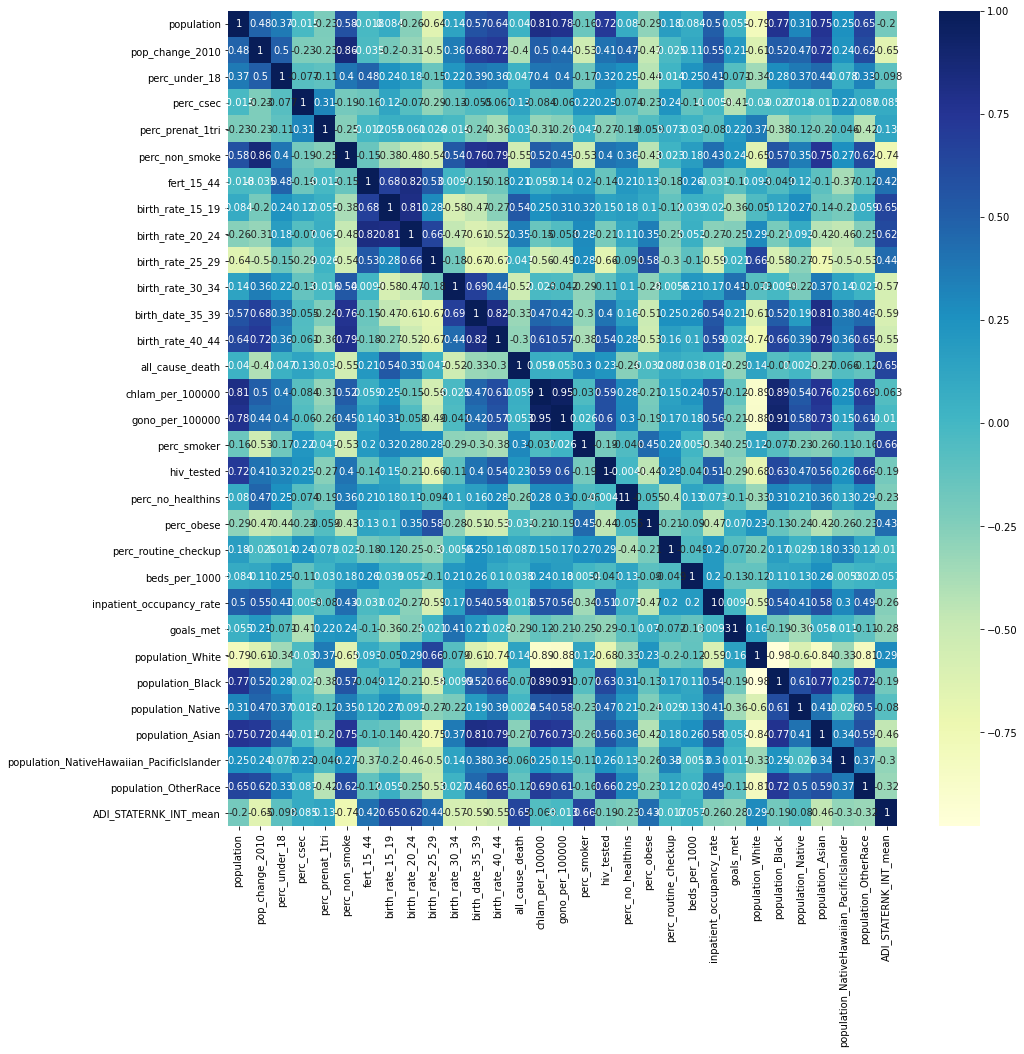

In [19]:
fig, ax = plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(merged.corr(), cmap="YlGnBu", annot=True)

In [20]:
lm = LinearRegression() #creating linear regression object
lm.fit(X_train, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train))) #getting MSE for train data

cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #creating k-fold cross validation object
score_lm = cross_val_score(lm, X_train, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting CV scores for linear regression
lm_MSE_CV = np.abs(np.mean(score_lm)) #getting average CV error for linear regression
print("Linear Regression CV error:", lm_MSE_CV) #printing average CV error for linear regression

Train R-squared:  0.8678614558742271
Train MSE: 0.07
Linear Regression CV error: 0.4707163415943357


Train R-squared:  0.43817090601079445
Train MSE: 0.31
Linear Regression CV error: 0.4707163415943357


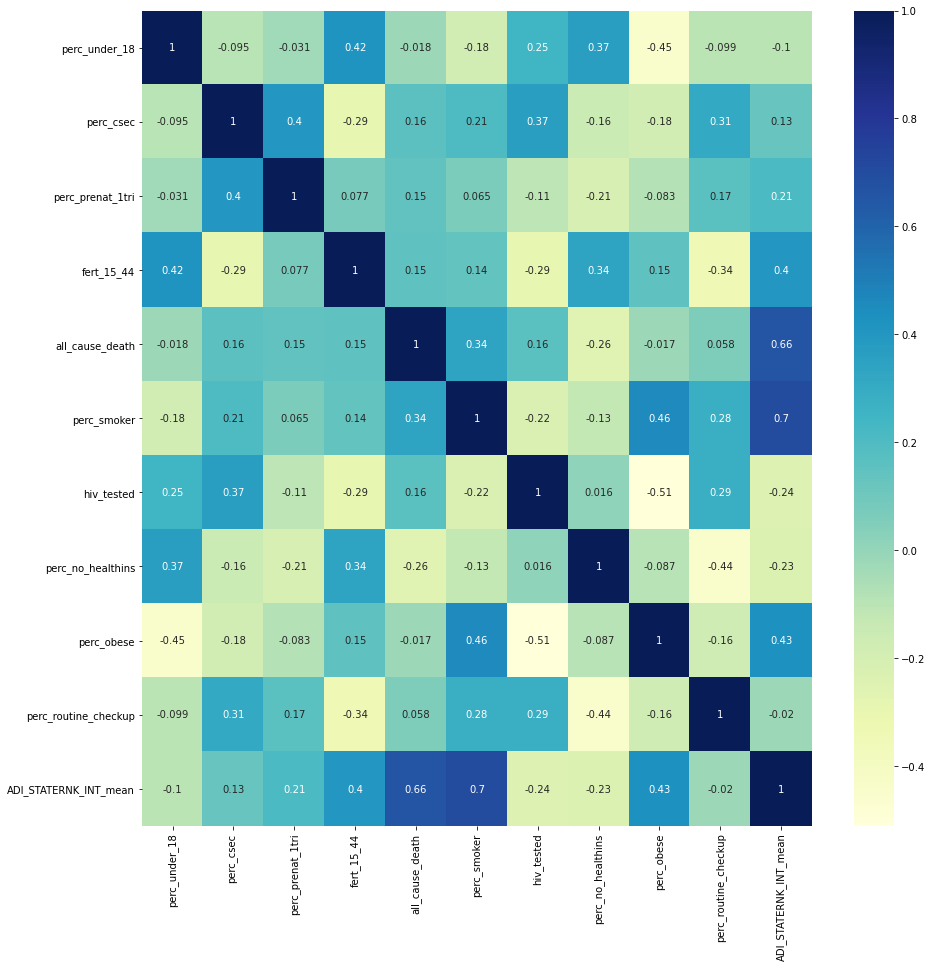

In [21]:
X_train_corr  = X_train.drop(columns = ['population', 'population_White', 'perc_non_smoke', 'population_Black', 'population_Native', 'population_Asian', 'population_NativeHawaiian_PacificIslander', 'population_OtherRace', 'beds_per_1000', 'gono_per_100000', 
                                        'chlam_per_100000', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44', 'pop_change_2010', 'inpatient_occupancy_rate'])
X_test_corr  = X_test.drop(columns = ['population', 'population_White', 'perc_non_smoke', 'population_Black', 'population_Native', 'population_Asian', 'population_NativeHawaiian_PacificIslander', 'population_OtherRace', 'beds_per_1000', 'gono_per_100000', 
                                        'chlam_per_100000', 'pop_change_2010','birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'birth_rate_40_44', 'inpatient_occupancy_rate'])

lm = LinearRegression() #creating linear regression object
lm.fit(X_train_corr, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train_corr, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train_corr))) #getting MSE for train data!

cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #creating k-fold cross validation object
score_lm = cross_val_score(lm, X_train_corr, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting CV scores for linear regression
lm_MSE_CV_corr = np.abs(np.mean(score_lm)) #getting average CV error for linear regression
print("Linear Regression CV error:", lm_MSE_CV) #printing average CV error for linear regression

fig, ax = plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(X_train_corr.corr(), cmap="YlGnBu", annot=True)

In [22]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
lm_poly = LinearRegression(normalize=True) #creating linear regression object
cross_val = KFold(n_splits=10, random_state=None, shuffle=False) #setting up 10-fold cross-validation
errors = [] #creating empty list to score average CV errors

for i in range(2,4): #iterating through degrees 2-7
    poly = PolynomialFeatures(degree=i) #polynomial transformation object
    X_poly_train = poly.fit_transform(X_train) #transforming training predictors
    model = lm_poly.fit(X_poly_train, y_train) #fitting polynomial predictors to regression
    scores = cross_val_score(model, X_poly_train, y_train, 
                             scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1) #getting errors across 10 folds
    print("Degree-"+str(i)+" polynomial MSE: " + str(np.mean(np.abs(scores))) + ", standard_dev: " + str(np.std(scores)))
    errors.append(np.mean(np.abs(scores))) #appending average MSE to errors list

Degree-2 polynomial MSE: 2.4299236038668095, standard_dev: 6.1941561459712045
Degree-3 polynomial MSE: 5.767557235178799, standard_dev: 16.324286745520734


In [23]:
poly_minerror = np.min((errors)) #storing the min CV error
print('Minimum CV error for polynomial regression (degree=2):', poly_minerror)

Minimum CV error for polynomial regression (degree=2): 2.4299236038668095


In [24]:
from sklearn.feature_selection import SequentialFeatureSelector
model= LinearRegression(normalize=True) #creating model object
predictors = X_train.columns.values #saving column names of predictors
CV_scores = [] #creating empty list to score average CV errors

for i in range(1, np.shape(X_train)[1]): #looping through n-1 features
    print("Num Features:",i)
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = i, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv=10) 
    sfs = sfs.fit(X_train, y_train) #selecting i features using training data
    print("\tFeatures selected:", list(predictors[sfs.get_support()])) #getting selected features for given i
    x_subset = sfs.transform(X_train) #transforming predictors dataframe based on selected features
    CV_error = np.mean(cross_val_score(model, x_subset, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting mean cv score for linear regression fitted to training data with selected features
    CV_scores.append(CV_error) #appending average CV error to CV scores list
    print("\tCV_Error: %10.3f"%CV_error)

Num Features: 1
	Features selected: ['birth_rate_30_34']
	CV_Error:     -0.474
Num Features: 2
	Features selected: ['birth_rate_30_34', 'population_Native']
	CV_Error:     -0.437
Num Features: 3
	Features selected: ['birth_rate_30_34', 'perc_smoker', 'population_Native']
	CV_Error:     -0.402
Num Features: 4
	Features selected: ['perc_prenat_1tri', 'birth_rate_30_34', 'perc_smoker', 'population_Native']
	CV_Error:     -0.376
Num Features: 5
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_30_34', 'perc_smoker', 'population_Native']
	CV_Error:     -0.335
Num Features: 6
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_30_34', 'perc_smoker', 'population_Native', 'population_OtherRace']
	CV_Error:     -0.276
Num Features: 7
	Features selected: ['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_rate_30_34', 'perc_smoker', 'population_Native', 'population_OtherRace']
	CV_Error:     -0.276
Num Features: 8
	Features selected: ['perc_csec', 'perc_pre

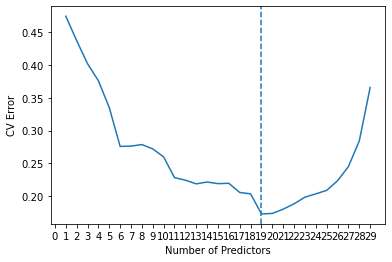

In [25]:
CV_scores =np.abs(CV_scores) #get the absolute value of the CV errors since we used negative MSE above
MSE_LR = np.min(CV_scores) #save the lowest MSE

x_graph = list(range(1,len(predictors))) #store range of features
best_CV = (np.where(CV_scores == np.min(CV_scores))[0])+1 #storing lowest CV error
plt.plot(x_graph,CV_scores) #plotting CV error for each # of features
plt.xlabel("Number of Predictors") #labeling x axis
plt.xticks(range(len(predictors))) #specifying x ticks
plt.ylabel("CV Error") #labeling y axis
plt.axvline(x=best_CV,linestyle='--') #adding vertical line for lowest CV error
plt.show() #showing plot

In [37]:
X_train_fs = X_train[['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'gono_per_100000', 'perc_smoker', 'hiv_tested', 'perc_no_healthins', 'perc_obese', 'beds_per_1000', 'population_White', 'population_Black', 'population_Native', 'population_Asian', 'population_OtherRace', 'ADI_STATERNK_INT_mean']]

X_test_fs = X_test[['perc_csec', 'perc_prenat_1tri', 'birth_rate_15_19', 'birth_rate_20_24', 'birth_rate_25_29', 'birth_rate_30_34', 'birth_date_35_39', 'gono_per_100000', 'perc_smoker', 'hiv_tested', 'perc_no_healthins', 'perc_obese', 'beds_per_1000', 'population_White', 'population_Black', 'population_Native', 'population_Asian', 'population_OtherRace', 'ADI_STATERNK_INT_mean']]

In [39]:
lm = LinearRegression() #creating linear regression object
lm.fit(X_train_fs, y_train) #fitting train data to model
print("Train R-squared: ", lm.score(X_train_fs, y_train)) #getting train model R-squared
print("Train MSE: %.2f"% mean_squared_error(y_train, lm.predict(X_train_fs))) #getting MSE for train data


Train R-squared:  0.8285365925448595
Train MSE: 0.09


In [28]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
feature_names=X_train.columns.values #storing feature names

model_ridge = Ridge(normalize=True) #creating ridge model object
errors= [] #empty list to store errors
coef = [] #empty list to store coefficient estimates for graphing 


alphas = np.logspace(-5, 5, 300) #setting logspace range for alphas
for a in alphas: #iterating through alphas
    model_ridge.set_params(alpha=a) #setting alpha parameter for ridge model
    model_ridge.fit(X_train, y_train) #fitting model to training data
    CV_error = np.mean(cross_val_score(model_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting average CV error for specific alpha using training data
    errors.append(CV_error) #storing average CV error in list
    coef.append(model_ridge.coef_) #storing coefficient estimates in list for graphing later
    
errors = np.abs(errors) #storing absolute value of errors bc we used neg MSE above
print("Min error: ", np.min(errors)) #printing min CV error
ridge_ME = np.min(errors) #storing min error for model selection later
index_ME = (np.where(errors == np.min(errors))[0]) #storing index for min CV error to get best alpha
print("Best alpha: ", alphas[index_ME]) #printing best alpha

Min error:  0.2332431780156587
Best alpha:  [0.11138398]


In [29]:
model_lasso = Lasso(normalize=True, max_iter = 100000) #creating lasso model object
errors_lasso = [] #empty list to store errors
coef_lasso = [] #empty list to store coefficient estimates for graphing 

alphas = np.logspace(-5, 5, 300) #setting logspace range for alphas
for a in alphas: #iterating through alphas
    model_lasso.set_params(alpha=a) #setting model parameter to specific alpha
    model_lasso.fit(X_train, y_train) #fitting lasso model to training data
    CV_error = np.mean(cross_val_score(model_lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    #getting mean CV error using training data
    errors_lasso.append(CV_error) #appending mean CV error to list for graphing
    coef_lasso.append(model_lasso.coef_) #appending coefficient weights to list for graphing
    
errors_lasso = np.abs(errors_lasso) #getting asbolute value since negative MSE is used above
print("Min error: ", np.min(errors_lasso)) #printing min error
lasso_ME = np.min(errors_lasso) #storing min error
lasso_index_ME = (np.where(errors_lasso == np.min(errors_lasso))[0])
#storing index of min error to get best alpha
print("Best alpha: ", alphas[lasso_index_ME]) #getting best alpha using index stored in line above

Min error:  0.24496552136056873
Best alpha:  [0.00203092]


In [40]:
print('Avg CV MSE for Linear Regression: %.4f'% lm_MSE_CV)
print('Avg CV MSE for Linear Regression with Manual Feature Selection: %.4f'% lm_MSE_CV_corr)
print('Lowest SFS Linear Regression CV MSE, 19 features: %.4f'% MSE_LR)
print('Lowest Ridge CV MSE with best alpha: %.4f'% ridge_ME)
print('Lowest Lasso CV MSE with best alpha: %.4f'% lasso_ME)

Avg CV MSE for Linear Regression: 0.4707
Avg CV MSE for Linear Regression with Manual Feature Selection: 0.4748
Lowest SFS Linear Regression CV MSE, 19 features: 0.1730
Lowest Ridge CV MSE with best alpha: 0.2332
Lowest Lasso CV MSE with best alpha: 0.2450


In [42]:
lm = LinearRegression() #create linear reg object
lm.fit(X_train, y_train) #fitting to training data
lm_model_pred_y = lm.predict(X_test) #using fit model to predict y for test data
lm_model_test_MSE = mean_squared_error(lm_model_pred_y, y_test) #get test MSE
print("Linear Regression Test MSE:", lm_model_test_MSE)

lm = LinearRegression() #create linear reg object
lm.fit(X_train_corr, y_train) #fitting to training data
lm_model_pred_y = lm.predict(X_test_corr) #using fit model to predict y for test data
lm_corr_test_MSE = mean_squared_error(lm_model_pred_y, y_test) #get test MSE
print("Linear Regression Corr Test MSE:", lm_corr_test_MSE)

sfs = SequentialFeatureSelector(model, 
                                n_features_to_select = 19, 
                                direction="forward",
                                scoring='neg_mean_squared_error',
                                cv=10) #create SFS using n=17
sfs = sfs.fit(X_train, y_train) #selecting 5 features using training data
x_subset = sfs.transform(X_train) #transforming x train data
x_subset_test = sfs.transform(X_test) #transforming x test data
lm.fit(x_subset, y_train) #fitting SFS linear model using transformed x train data
y_pred = lm.predict(x_subset_test) #predict y test using transformed x data and fitted model
sfs_MSE = mean_squared_error(y_pred, y_test) #get test MSE
print("SFS Linear Regression Test MSE:", sfs_MSE)

model_ridge.set_params(alpha=alphas[index_ME]) #set params for ridge using best alpha
y_pred = model_ridge.predict(X_test) #predict y using x test data
MSE_test_ridge = mean_squared_error(y_test, y_pred) #get test MSE
print("Ridge Regression Test MSE:", MSE_test_ridge)

model_lasso.set_params(alpha=alphas[lasso_index_ME]) #set params for ridge using best alpha
y_pred = model_lasso.predict(X_test) #predict y using x test data
MSE_test_lasso = mean_squared_error(y_test, y_pred) #get test MSE
print("Lasso Regression Test MSE:", MSE_test_lasso)

Linear Regression Test MSE: 0.7014178460976909
Linear Regression Corr Test MSE: 0.7031776644843599
SFS Linear Regression Test MSE: 0.5158124224460772
Ridge Regression Test MSE: 0.9773717253477117
Lasso Regression Test MSE: 0.9773913043478258


In [32]:
import statsmodels.api as sm
from regressors import stats
import itertools

In [43]:
lm = LinearRegression()
lm.fit(X_train, y_train)

coefs = []
coefs.append(lm.intercept_)
for coef in lm.coef_:
    coefs.append(coef)

pd.DataFrame(zip(X_train.columns, coefs, stats.coef_pval(lm, X_train, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])

,feature,coefficient estimate,p-value
0,population,-2.660233e+01,4.655090e-04
1,pop_change_2010,8.286520e-07,9.556800e-13
2,perc_under_18,-2.654244e-02,3.582890e-01
3,perc_csec,-2.687695e-02,3.272562e-01
4,perc_prenat_1tri,-1.177608e-01,1.171063e-12
5,perc_non_smoke,8.755044e-02,0.000000e+00
6,fert_15_44,-2.437560e-02,1.883565e-01
7,birth_rate_15_19,1.359640e-01,5.733233e-04
8,birth_rate_20_24,-1.417802e-02,4.444877e-01
9,birth_rate_25_29,-2.990086e-02,7.664025e-11


In [44]:
lm = LinearRegression()
lm.fit(X_train_fs, y_train)
y_pred = lm.predict(X_test_fs)

coefs = []
coefs.append(lm.intercept_)
feature_names = ['intercept']
for col in X_train_fs.columns:
    feature_names.append(col)
for coef in lm.coef_:
    coefs.append(coef)

results = pd.DataFrame(zip(feature_names, coefs, stats.coef_pval(lm, X_train_fs, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])
results.to_csv('regression_results.csv')

,feature,coefficient estimate,p-value
0,perc_csec,-32.811900,1.023813e-07
1,perc_prenat_1tri,-0.095552,3.342140e-10
2,birth_rate_15_19,0.093918,0.000000e+00
3,birth_rate_20_24,0.050086,4.108741e-03
4,birth_rate_25_29,-0.007296,5.819559e-03
5,birth_rate_30_34,-0.005897,1.715649e-01
6,birth_date_35_39,0.015134,2.546807e-03
7,gono_per_100000,0.048449,4.244524e-07
8,perc_smoker,-0.003067,3.346355e-07
9,hiv_tested,-0.051394,2.352607e-05


In [ ]:
lm = LinearRegression()
lm.fit(X_train_corr, y_train)

coefs = []
coefs.append(lm.intercept_)
for coef in lm.coef_:
    coefs.append(coef)

pd.DataFrame(zip(X_train_corr.columns, coefs, stats.coef_pval(lm, X_train_corr, y_train)), columns = ['feature', 'coefficient estimate', 'p-value'])

,feature,coefficient estimate,p-value
0,perc_under_18,6.677790,0.381692
1,perc_csec,-0.026205,0.676671
2,perc_prenat_1tri,-0.001048,0.976479
3,fert_15_44,-0.032247,0.057222
4,all_cause_death,-0.009954,0.581267
5,perc_smoker,0.002038,0.000002
6,hiv_tested,0.008291,0.801848
7,perc_no_healthins,0.012926,0.447285
8,perc_obese,0.062838,0.072011
9,perc_routine_checkup,-0.032025,0.269051
